### Imported Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

### Feature Extraction Functions

In [2]:
def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    df = df.merge(pd.read_csv("all_times.csv"), how='left').fillna(1)
    return df#.drop(['spread'], axis=1).drop(['dom'], axis=1)
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def target_encoding(df):
    enc = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 10, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        tmean = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
        enc[idx_2] = df['stock_id'].iloc[idx_2].map(tmean)
    df['target_mean_enc'] = enc
    return df

def generate_feature_seconds(features, df, feats, seconds=[300]):
    for second in seconds:
        res = pd.DataFrame(
            df.query(f'{300-second} <= seconds_in_bucket < {seconds[0]}')
            .groupby(['time_id']).agg(feats)
        ).reset_index()
        res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
        res = res.add_suffix('_' + str(second))
        features = pd.merge(
            features, res, 
            how='left', 
            left_on='time_id', 
            right_on=f'time_id_{second}'
        )
        features = features.drop([f'time_id_{second}'], axis=1)
    return features

def generate_target(df, target, second=300):
    features = pd.DataFrame(
        df.query(f'seconds_in_bucket >= {second}')
        .groupby(['time_id']).agg(target)
    ).reset_index()
    features.columns = ['_'.join(feat).rstrip('_') for feat in features.columns]
    return features

def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)


def calc_dispersion(df):
    bspread = df['bid_price1'] - df['bid_price2']
    aspread = df['ask_price2'] - df['ask_price1']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']


def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d


def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

def log_returns(waps):
    return np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

def weighted_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2)/log_returns.count())

def quarticity(s):
    return (s.count()/3) * np.sum(s**4)

### Generate Features for First 5 Minutes of Each Stock 

In [3]:
def concat_features(stock_id, df):
    file = f"individual_book_train/stock_{stock_id}.csv"        
    return pd.concat([df, generate_features(file)])

def process_stocks(stock_ids):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(concat_features)(stock_id, df) for stock_id in stock_ids
    )
    # lastly import pre-computed beta coefficients for all stock_ids
    return import_beta(target_encoding(pd.concat(df, ignore_index = True)))

def generate_features(file_path):
    df = pd.read_csv(file_path)
    
    # fill seconds
    df = df.groupby('time_id').apply(fill_seconds).reset_index(drop=True)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    df["slope"], _ = calc_slope(df)
    df["dispersion"], _ = calc_dispersion(df)
    df["price_impact"], _ = calc_price_impact(df)
    df["ofi"] = calc_ofi(df)
    df["turn_over"] = calc_tt1(df)
    
    
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean, np.std],#, mad, np.max, np.sum],
        'wap2':[np.mean, np.std],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean, np.std],
        'log_returns2':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean, np.sted],
        'wap_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'price_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'price_diff2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'ask_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean, np.std],#, mad, np.max, np.sum],
        'slope':[np.mean, np.std],#, mad, np.max, np.sum],
        'dispersion':[np.mean, np.std],#, mad, np.max, np.sum],
        'price_impact':[np.mean, np.std],#, mad, np.max, np.sum],
        'ofi':[np.mean, np.std],#, mad, np.max, np.sum],
        'turn_over':[np.mean, np.std]#, mad, np.max, np.sum],
    }
  
    
    
    # target realized volatility for next 300 second (5 min window in time_id)
    feature = generate_target(
        df, target=target_dict, 
        second=300  # target volatility is for next 300 second (no overlap)
    )
    
    # obtain features over entire 5 mins or last 2.5 mins..
    feature = generate_feature_seconds(
        feature, df, 
        feats=feature_dict, 
        seconds=[300, 200, 100]  # features generated for each second interval (different widths)
    )

    #create stock_id
    feature['stock_id'] = int(file_path.split('/')[1].split('_')[1].split('.')[0])
    feature['time_id'] = feature['time_id'].apply(int)
    
    return feature

b = process_stocks([0, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   23.0s finished


In [4]:
b

,time_id,target_realized_volatility,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns_mad_300,log_returns_amax_300,...,slope_mean_300,dispersion_mean_300,price_impact_mean_300,ofi_mean_300,turn_over_mean_300,stock_id,target_mean_enc,beta,dom,spread
0,5,0.002954,1.003597,1.003512,0.003394,0.000196,4.521321e-10,7.138250e-06,0.000089,0.001049,...,120915.510985,0.000291,-0.000065,12.147157,32.233723,0,0.002961,1.208072,313.922175,0.000865
1,11,0.000981,0.999987,0.999983,0.000699,0.000040,2.123766e-12,8.823633e-07,0.000011,0.000239,...,64245.564144,0.000211,-0.000089,-0.240000,-31.414625,0,0.002997,1.719756,380.683774,0.000432
2,16,0.001295,0.999960,1.000110,0.001983,0.000115,1.070617e-10,1.729093e-06,0.000037,0.000799,...,8893.765208,0.000303,-0.000050,-0.230000,-77.330797,0,0.002982,7.164047,417.199888,0.000733
3,31,0.001776,0.999219,0.998835,0.001863,0.000108,1.551546e-10,-5.516464e-06,0.000029,0.000757,...,76943.082501,0.000342,-0.000067,-3.180000,-108.809963,0,0.002982,6.559597,465.014775,0.000898
4,62,0.001520,0.999769,0.999684,0.001131,0.000065,3.550845e-11,-2.164288e-06,0.000017,0.000269,...,117185.528524,0.000165,-0.000049,1.496667,-99.038834,0,0.002962,0.680616,332.463664,0.000401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7655,32751,0.002212,1.000155,1.000018,0.002995,0.000173,3.013173e-10,-3.739256e-06,0.000076,0.000782,...,262353.682815,0.000184,-0.000091,-0.326667,26.447079,1,0.003233,0.225453,285.711186,0.000602
7656,32753,0.008499,1.003102,1.002956,0.006710,0.000388,2.461446e-08,5.595932e-05,0.000209,0.003866,...,201255.340990,0.000256,-0.000077,19.440000,-46.340728,1,0.003229,28.996320,568.986705,0.000928
7657,32758,0.002108,1.000470,1.000498,0.002320,0.000134,1.159275e-10,3.521505e-06,0.000056,0.000570,...,54478.203076,0.000231,-0.000063,3.310000,29.405633,1,0.003224,1.602334,429.906110,0.000654
7658,32763,0.002728,1.001599,1.001610,0.002573,0.000149,1.184751e-10,1.334694e-05,0.000087,0.000798,...,25486.478966,0.000216,-0.000103,13.496667,-17.196034,1,0.003225,3.980220,523.056313,0.000418


## Process Features for All Stocks

In [5]:
all_stocks = process_stocks(pd.read_csv("all_times.csv").stock_id.unique())
all_stocks

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  4.8min finished


,time_id,target_realized_volatility,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns_mad_300,log_returns_amax_300,...,slope_mean_300,dispersion_mean_300,price_impact_mean_300,ofi_mean_300,turn_over_mean_300,stock_id,target_mean_enc,beta,dom,spread
0,5,0.002954,1.003597,1.003512,0.003394,0.000196,4.521321e-10,7.138250e-06,0.000089,0.001049,...,120915.510985,0.000291,-0.000065,12.147157,32.233723,0,0.002943,1.208072,313.922175,0.000865
1,11,0.000981,0.999987,0.999983,0.000699,0.000040,2.123766e-12,8.823633e-07,0.000011,0.000239,...,64245.564144,0.000211,-0.000089,-0.240000,-31.414625,0,0.002974,1.719756,380.683774,0.000432
2,16,0.001295,0.999960,1.000110,0.001983,0.000115,1.070617e-10,1.729093e-06,0.000037,0.000799,...,8893.765208,0.000303,-0.000050,-0.230000,-77.330797,0,0.002985,7.164047,417.199888,0.000733
3,31,0.001776,0.999219,0.998835,0.001863,0.000108,1.551546e-10,-5.516464e-06,0.000029,0.000757,...,76943.082501,0.000342,-0.000067,-3.180000,-108.809963,0,0.002974,6.559597,465.014775,0.000898
4,62,0.001520,0.999769,0.999684,0.001131,0.000065,3.550845e-11,-2.164288e-06,0.000017,0.000269,...,117185.528524,0.000165,-0.000049,1.496667,-99.038834,0,0.002974,0.680616,332.463664,0.000401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.002899,0.999751,0.999942,0.002284,0.000132,2.117007e-10,-2.858852e-06,0.000052,0.000782,...,49495.443105,0.000317,-0.000089,4.236667,-102.382279,126,0.003887,0.895436,418.205006,0.000870
428928,32753,0.003454,1.001470,1.001513,0.002217,0.000128,9.484441e-11,3.674218e-06,0.000052,0.000569,...,211041.684369,0.000245,-0.000047,3.150000,-28.969928,126,0.003887,-1.346971,222.682585,0.000670
428929,32758,0.002792,1.000656,1.000586,0.001386,0.000080,3.031629e-11,-2.437732e-06,0.000022,0.000443,...,80550.060573,0.000263,-0.000110,2.726667,-37.164464,126,0.003904,0.904714,346.025217,0.000754
428930,32763,0.002379,1.001787,1.001794,0.002783,0.000161,1.960849e-10,6.737309e-06,0.000085,0.000887,...,95588.192176,0.000223,-0.000061,-2.323333,-34.701799,126,0.003904,-0.099107,438.588531,0.000526


In [31]:
all_stocks = all_stocks.drop(index=132867)

### Defining X for LightGBM

In [32]:
all_stocks_X = all_stocks.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature 
#all_stocks_X.iloc[:,:] = MinMaxScaler().fit(all_stocks_X).transform(all_stocks_X)
all_stocks_X

,wap_mean_300,wap2_mean_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns_mad_300,log_returns_amax_300,log_returns_sum_300,log_returns2_realized_volatility_300,...,slope_mean_300,dispersion_mean_300,price_impact_mean_300,ofi_mean_300,turn_over_mean_300,stock_id,target_mean_enc,beta,dom,spread
0,1.003597,1.003512,0.003394,0.000196,4.521321e-10,7.138250e-06,0.000089,0.001049,0.002134,0.005032,...,120915.510985,0.000291,-0.000065,12.147157,32.233723,0,0.002943,1.208072,313.922175,0.000865
1,0.999987,0.999983,0.000699,0.000040,2.123766e-12,8.823633e-07,0.000011,0.000239,0.000264,0.001448,...,64245.564144,0.000211,-0.000089,-0.240000,-31.414625,0,0.002974,1.719756,380.683774,0.000432
2,0.999960,1.000110,0.001983,0.000115,1.070617e-10,1.729093e-06,0.000037,0.000799,0.000517,0.003583,...,8893.765208,0.000303,-0.000050,-0.230000,-77.330797,0,0.002985,7.164047,417.199888,0.000733
3,0.999219,0.998835,0.001863,0.000108,1.551546e-10,-5.516464e-06,0.000029,0.000757,-0.001649,0.002422,...,76943.082501,0.000342,-0.000067,-3.180000,-108.809963,0,0.002974,6.559597,465.014775,0.000898
4,0.999769,0.999684,0.001131,0.000065,3.550845e-11,-2.164288e-06,0.000017,0.000269,-0.000647,0.002412,...,117185.528524,0.000165,-0.000049,1.496667,-99.038834,0,0.002974,0.680616,332.463664,0.000401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,0.999751,0.999942,0.002284,0.000132,2.117007e-10,-2.858852e-06,0.000052,0.000782,-0.000855,0.004503,...,49495.443105,0.000317,-0.000089,4.236667,-102.382279,126,0.003887,0.895436,418.205006,0.000870
428928,1.001470,1.001513,0.002217,0.000128,9.484441e-11,3.674218e-06,0.000052,0.000569,0.001099,0.003652,...,211041.684369,0.000245,-0.000047,3.150000,-28.969928,126,0.003887,-1.346971,222.682585,0.000670
428929,1.000656,1.000586,0.001386,0.000080,3.031629e-11,-2.437732e-06,0.000022,0.000443,-0.000729,0.002686,...,80550.060573,0.000263,-0.000110,2.726667,-37.164464,126,0.003904,0.904714,346.025217,0.000754
428930,1.001787,1.001794,0.002783,0.000161,1.960849e-10,6.737309e-06,0.000085,0.000887,0.002014,0.004316,...,95588.192176,0.000223,-0.000061,-2.323333,-34.701799,126,0.003904,-0.099107,438.588531,0.000526


### Defining y for LightGBM

In [33]:
all_stocks_y = all_stocks[['target_realized_volatility', 'stock_id', 'time_id']]
len(all_stocks_y.time_id.unique())

3830

In [34]:
all_stocks_y

,target_realized_volatility,stock_id,time_id
0,0.002954,0,5
1,0.000981,0,11
2,0.001295,0,16
3,0.001776,0,31
4,0.001520,0,62
...,...,...,...
428927,0.002899,126,32751
428928,0.003454,126,32753
428929,0.002792,126,32758
428930,0.002379,126,32763


In [35]:
len(pd.read_csv("all_times.csv").time_id.unique())

3462

Note: Including stock_id and time_id for logging predictions for app (target_realized_volatility is only target)

## Training LightGBM

### Model Helper Functions

In [36]:
EPSILON = 0 #1e-10 set epsilon to zero as removed zero row for realized volatility (ONLY ONE ROW! angryyy )

def compute_importance(model, features, typ='gain'):
    return pd.DataFrame(
        model.feature_importance(importance_type=typ),
        index=features,
        columns=['importance']
    ).sort_values('importance')

def plot_importance(importance, title='', save_to_file=None):
    fig, ax = plt.subplots(figsize=(8, 12))
    importance.plot.barh(ax=ax)
    if title: plt.title(title)
    plt.tight_layout()
    do = plt.savefig(save_to_file) if save_to_file else plt.show()
    plt.close()
    
def compute_mean_importance(importance):
    res = importance[0].copy()
    res['importance'] = np.mean(
        np.array([df['importance'].values for df in importance]), 
        axis=0
    )
    return res
    
def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

### Nested 5-Fold Cross-Validation

In [37]:
%%time
test = pd.DataFrame({'target_realized_volatility':[],'predicted_volatility': [],'time_id':[], 'stock_id':[]})
all_models = []
split_importance = []
gain_importance = []
train_scores = []
inner_k = 5
outer_k = 5

seed = 42

# some params taken from research paper (link @ bottom of notebook)
params = {
    "objective": "regression",
    "metric": "rmse", 
    "boosting_type": "gbdt",
    "feature_fraction": 0.8,  
    "bagging_fraction": 0.8,
    "learning_rate": 0.01,
    #"lambda_l1": 1,
    #"lambda_l2": 1,
    #"early_stopping_rounds": 100,
    "lambda_l1": 2,
    "lambda_l2": 2,
    "extra_trees": True,
    "force_col_wise": True,
  }


outer_kfold = KFold(n_splits=outer_k, random_state=42, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(all_stocks_X, all_stocks_y)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = all_stocks_X.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_train = all_stocks_y.iloc[outer_train_idx].reset_index(drop=True)
    X_outer_test = all_stocks_X.iloc[outer_test_idx].reset_index(drop=True)
    y_outer_test = all_stocks_y.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))
    inner_scores = 0.0
    models = []
    inner_kfold = KFold(n_splits= inner_k, random_state=42, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        y_inner_train = y_outer_train.iloc[inner_train_idx].reset_index(drop=True)['target_realized_volatility']
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)
        y_inner_valid = y_outer_train.iloc[inner_valid_idx].reset_index(drop=True)['target_realized_volatility']
    
        lgbm_train = lgbm.Dataset(
            X_inner_train, 
            y_inner_train, 
            weight = 1 / (np.square(y_inner_train.values)+EPSILON)         # weighting rmspe
        )
        lgbm_valid = lgbm.Dataset(
            X_inner_valid, 
            y_inner_valid, 
            reference = lgbm_train, 
            weight = 1 / (np.square(y_inner_valid.values)+EPSILON)        # weighting rmspe
        )
        # model training
        model = lgbm.train(
            params=params,
            train_set=lgbm_train,
            valid_sets=[lgbm_train, lgbm_valid],
            num_boost_round=10000,       
            early_stopping_rounds=50,
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100)]
        )
        # validation 
        y_inner_pred = model.predict(X_inner_valid, num_iteration=model.best_iteration)
        RMSPE = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred)
        )
        
        print("\t"+"*" * 100)
        print(f'\tInner Validation RMSPE: {RMSPE}')
        print("\t"+"*" * 100)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        models.append(model)
        
        # record feature importances by gain and split
        features = list(X_inner_train.columns.values)
        gain_importance.append(compute_importance(model, features, typ='gain'))
        split_importance.append(compute_importance(model, features, typ='split'))
    
    # store all models for prediction in oof evaluation
    all_models.append(models)
    train_scores.append(inner_scores)
    
    # out of fold test set
    for model in all_models[outer_fold]:
        y_outer_pred = model.predict(X_outer_test, num_iteration=model.best_iteration)
        target += y_outer_pred / len(all_models[outer_fold])
        
    y_outer_test = y_outer_test.assign(predicted_volatility = target)
    test = pd.concat([test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************



C:\Users\imgap\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 274515, number of used features: 39
[LightGBM] [Info] Start training from score 0.001181
[100]	training's rmse: 0.000345665	training's RMSPE: 0.23655	valid_1's rmse: 0.000377195	valid_1's RMSPE: 0.25841
[200]	training's rmse: 0.000331962	training's RMSPE: 0.22717	valid_1's rmse: 0.000372995	valid_1's RMSPE: 0.25556
[300]	training's rmse: 0.000323313	training's RMSPE: 0.22125	valid_1's rmse: 0.000369976	valid_1's RMSPE: 0.2535
[400]	training's rmse: 0.000317289	training's RMSPE: 0.21713	valid_1's rmse: 0.000369656	valid_1's RMSPE: 0.25329
	****************************************************************************************************
	Inner Validation RMSPE: 0.2527110980121303
	****************************************************************************************************

	********************
	*  Inner Fold : 2  *
	********************

[LightGBM] [Info] Total Bins 9802
[LightGBM] [In

[700]	training's rmse: 0.000306059	training's RMSPE: 0.20848	valid_1's rmse: 0.000355564	valid_1's RMSPE: 0.23998
	****************************************************************************************************
	Inner Validation RMSPE: 0.2397625093278122
	****************************************************************************************************

	********************
	*  Inner Fold : 2  *
	********************

[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 274516, number of used features: 39
[LightGBM] [Info] Start training from score 0.001197
[100]	training's rmse: 0.000348899	training's RMSPE: 0.23703	valid_1's rmse: 0.000361666	valid_1's RMSPE: 0.24677
[200]	training's rmse: 0.000335372	training's RMSPE: 0.22784	valid_1's rmse: 0.000352368	valid_1's RMSPE: 0.24043
[300]	training's rmse: 0.0003263	training's RMSPE: 0.22167	valid_1's rmse: 0.000346563	valid_1's RMSPE: 0.23647
[400]	training's rmse: 0.000320008	training's RMS

************************************************************************************************************************
Outer Fold : 3
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 274516, number of used features: 39
[LightGBM] [Info] Start training from score 0.001179
[100]	training's rmse: 0.000345311	training's RMSPE: 0.23647	valid_1's rmse: 0.000366302	valid_1's RMSPE: 0.24982
[200]	training's rmse: 0.00033144	training's RMSPE: 0.22697	valid_1's rmse: 0.000357514	valid_1's RMSPE: 0.24383
[300]	training's rmse: 0.000322445	training's RMSPE: 0.22081	valid_1's rmse: 0.000354419	valid_1's RMSPE: 0.24174
[400]	training's rmse: 0.000316651	training's RMSPE: 0.21684	valid_1's rmse: 0.000353591	valid_1's RMSPE: 0.24119
	**************************************

[1100]	training's rmse: 0.00029322	training's RMSPE: 0.20134	valid_1's rmse: 0.000329757	valid_1's RMSPE: 0.22244
[1200]	training's rmse: 0.000291234	training's RMSPE: 0.19998	valid_1's rmse: 0.000329587	valid_1's RMSPE: 0.22232
[1300]	training's rmse: 0.000289196	training's RMSPE: 0.19858	valid_1's rmse: 0.000329196	valid_1's RMSPE: 0.22206
[1400]	training's rmse: 0.000287363	training's RMSPE: 0.19732	valid_1's rmse: 0.000329103	valid_1's RMSPE: 0.222
[1500]	training's rmse: 0.000285675	training's RMSPE: 0.19616	valid_1's rmse: 0.000329001	valid_1's RMSPE: 0.22193
[1600]	training's rmse: 0.000284017	training's RMSPE: 0.19503	valid_1's rmse: 0.000328759	valid_1's RMSPE: 0.22177
[1700]	training's rmse: 0.000282443	training's RMSPE: 0.19394	valid_1's rmse: 0.000328784	valid_1's RMSPE: 0.22178
	****************************************************************************************************
	Inner Validation RMSPE: 0.22171845429648004
	**************************************************

[1200]	training's rmse: 0.000291996	training's RMSPE: 0.20019	valid_1's rmse: 0.000327651	valid_1's RMSPE: 0.22173
[1300]	training's rmse: 0.00029003	training's RMSPE: 0.19884	valid_1's rmse: 0.00032765	valid_1's RMSPE: 0.22173
	****************************************************************************************************
	Inner Validation RMSPE: 0.22157708404414508
	****************************************************************************************************

	********************
	*  Inner Fold : 2  *
	********************

[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 274516, number of used features: 39
[LightGBM] [Info] Start training from score 0.001180
[100]	training's rmse: 0.00034489	training's RMSPE: 0.23626	valid_1's rmse: 0.000371145	valid_1's RMSPE: 0.25207
[200]	training's rmse: 0.000331487	training's RMSPE: 0.22707	valid_1's rmse: 0.000360152	valid_1's RMSPE: 0.24461
[300]	training's rmse: 0.000322674	training's R

### Training Validation Result with 5-fold CV

In [38]:
print(f'Train Result RMSPE: {np.mean(train_scores)}')

Train Result RMSPE: 0.23849248381432053


In [39]:
train_scores

[0.23960494280660913,
 0.23476403604210616,
 0.23856355618189762,
 0.24186898370268728,
 0.2376609003383024]

## NOTE: Problem with using RMSPE when actual value near zero
* Removed single row with zero realized vol

### Testing Result with Nested 5-fold CV (test set is out of fold)

In [40]:
RMSPE = round(rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility']), 3)

print(f'Test Result RMSPE: {RMSPE}')

Test Result RMSPE: 0.237


## Mean Absolute Percentage Error

In [42]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1e-10))) 

print(mape(test['target_realized_volatility'],test['predicted_volatility']))

0.1663480230268988


### Write Predictions to CSV

In [43]:
test = test.astype({'time_id': int, 'stock_id': int})
test.to_csv("lightgbm_baseline_predict.csv")
test

,target_realized_volatility,predicted_volatility,time_id,stock_id
0,0.003397,0.003615,103,0
1,0.002993,0.004331,146,0
2,0.001094,0.001466,250,0
3,0.001711,0.001866,297,0
4,0.001197,0.001502,319,0
...,...,...,...,...
428926,0.004120,0.002778,32712,126
428927,0.003511,0.003412,32724,126
428928,0.010431,0.012858,32746,126
428929,0.001827,0.002394,32750,126


## Model Feature Importance

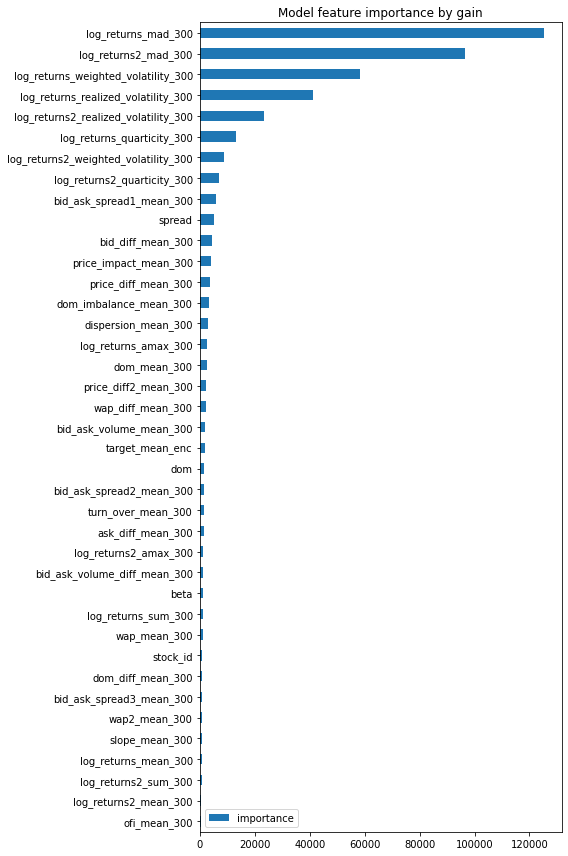

,feature_names,importance
0,ofi_mean_300,497.578106
1,log_returns2_mean_300,564.560024
2,log_returns2_sum_300,635.304558
3,log_returns_mean_300,678.705371
4,slope_mean_300,718.472497
5,wap2_mean_300,760.960810
6,bid_ask_spread3_mean_300,798.365102
7,dom_diff_mean_300,861.262246
8,stock_id,907.333711
9,wap_mean_300,989.506163


In [45]:
mean_gain_df = compute_mean_importance(gain_importance)
plot_importance(mean_gain_df, title='Model feature importance by gain')
mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
mean_gain_df.to_csv('gain_importance_mean.csv', index=False)
    
mean_gain_df

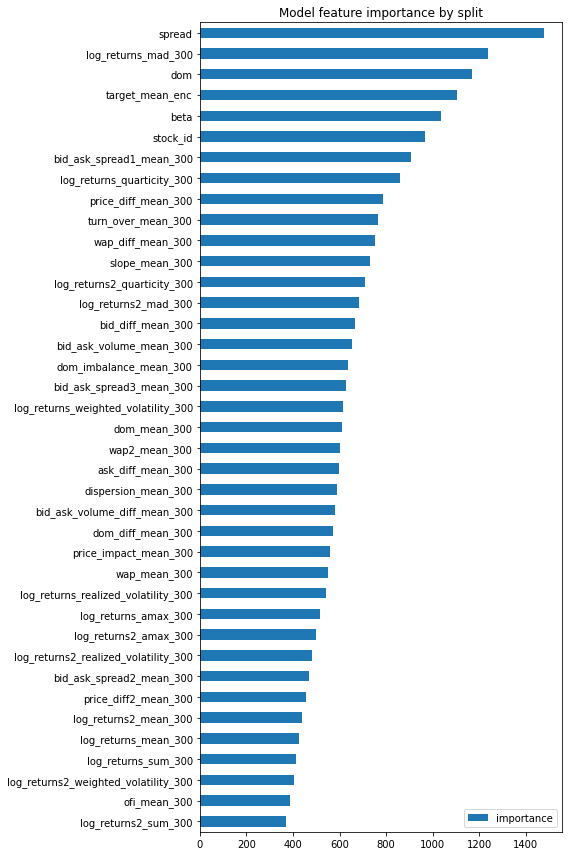

,feature_names,importance
0,log_returns2_sum_300,371.68
1,ofi_mean_300,387.64
2,log_returns2_weighted_volatility_300,403.88
3,log_returns_sum_300,414.80
4,log_returns_mean_300,423.84
5,log_returns2_mean_300,438.80
6,price_diff2_mean_300,457.56
7,bid_ask_spread2_mean_300,470.76
8,log_returns2_realized_volatility_300,482.00
9,log_returns2_amax_300,500.40


In [46]:
mean_split_df = compute_mean_importance(split_importance)
plot_importance(mean_split_df, title='Model feature importance by split')
mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
mean_split_df.to_csv('split_importance_mean.csv', index=False)

mean_split_df

### Reference Paper: LightGBM Based Optiver Realized Volatility Prediction
#### Link:  https://ieeexplore-ieee-org.ezproxy.library.sydney.edu.au/document/9543438